<a href="https://colab.research.google.com/github/riyaaaarane/reddit-analysis/blob/main/reddit_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import spacy
import re
import pandas as pd
nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('/content/work_culture_companies.csv')

In [4]:
df.head()

Company                                              Title  \
0  Facebook  Facebook needs to be investigated. They priori...   
1  Facebook  Am I wrong? Deleted both Facebook and instagra...   
2  Facebook  DISABLED ACCOUNT IN FB (FOR NO ABSOLUTELY NO R...   
3  Facebook  Apparently facebook is insinuating you are a p...   
4  Facebook  Good as they should! you can't just falsely ac...   

                                           Post Text       ID  Score  \
0  Lately, I’ve been noticing that Facebook’s alg...  1m0q6zl    512   
1  So I permanently deleted my Facebook and insta...  1ma8ux1    331   
2  AM I THE ONLY ONE WHO IS EXPERIENCING THIS? PL...  1mmmwa7    386   
3                                                NaN  1m9cn2i    295   
4                                                NaN  1mcifjc    277   

   Total Comments                                           Post URL  
0             356  https://www.reddit.com/r/facebook/comments/1m0...  
1             160  https://www.reddit.com/r/facebook/comments/1ma...  
2             689               https://i.redd.it/uh60cibmx7if1.jpeg  
3             108               https://i.redd.it/4sgtfmaqh3ff1.jpeg  
4              61               https://i.redd.it/b7v7tfo2quff1.jpeg

In [5]:
df.shape

(391, 7)

In [6]:
df.drop(['ID', 'Score', 'Post URL'], axis=1, inplace=True)

In [7]:
import string

#text cleaning
def clean_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = text.encode('latin1', 'ignore').decode('utf-8', 'ignore')  # Fix encoding issues
    text = text.lower()  # Lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\W+', ' ', text)  # Remove special characters, keep spaces
    return text.strip()

# Clean both Title and Post Text
df['cleaned_title'] = df['Title'].apply(clean_text)
df['cleaned_post'] = df['Post Text'].apply(clean_text)

print(df[['cleaned_title', 'cleaned_post']].head())

                                       cleaned_title  \
0  facebook needs to be investigated they priorit...   
1  am i wrong deleted both facebook and instagram...   
2  disabled account in fb for no absolutely no re...   
3  apparently facebook is insinuating you are a p...   
4  good as they should you cant just falsely accu...   

                                        cleaned_post  
0  lately ive been noticing that facebooks algori...  
1  so i permanently deleted my facebook and insta...  
2  am i the only one who is experiencing this pls...  
3                                                     
4                                                     


In [8]:
# Merge cleaned title and post into a single column
df['combined_text'] = df['cleaned_title'] + " " + df['cleaned_post']

In [9]:
def lemmatize_no_stopwords(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

# Apply on combined column
df['lemmas'] = df['combined_text'].apply(lemmatize_no_stopwords)


In [10]:
df.isna().sum()

Company             0
Title               0
Post Text         171
Total Comments      0
cleaned_title       0
cleaned_post        0
combined_text       0
lemmas              0
dtype: int64

In [11]:
df.drop(['Total Comments','Post Text','Title'], inplace=True , axis=1)

In [12]:
df.isna().sum()

Company          0
cleaned_title    0
cleaned_post     0
combined_text    0
lemmas           0
dtype: int64

# BAG OF WORDS

In [13]:
from collections import Counter

# Dictionary to store word frequencies per company
company_word_freqs = {}

for company, group in df.groupby("Company"):
    all_words = [word for lemmas in group["lemmas"] for word in lemmas]
    freq = Counter(all_words)

    # Convert to DataFrame
    word_freq_df = pd.DataFrame(freq.items(), columns=["Word", "Frequency"])
    word_freq_df = word_freq_df.sort_values(by="Frequency", ascending=False).reset_index(drop=True)

    company_word_freqs[company] = word_freq_df

# Example: Show Facebook’s top 10 words
print(company_word_freqs["Tesla"].head(10))

           Word  Frequency
0         tesla         18
1         model         12
2           new          9
3             y          9
4  supercharger          7
5         diner          6
6          open          4
7          dojo          4
8          long          4
9           fsd          4


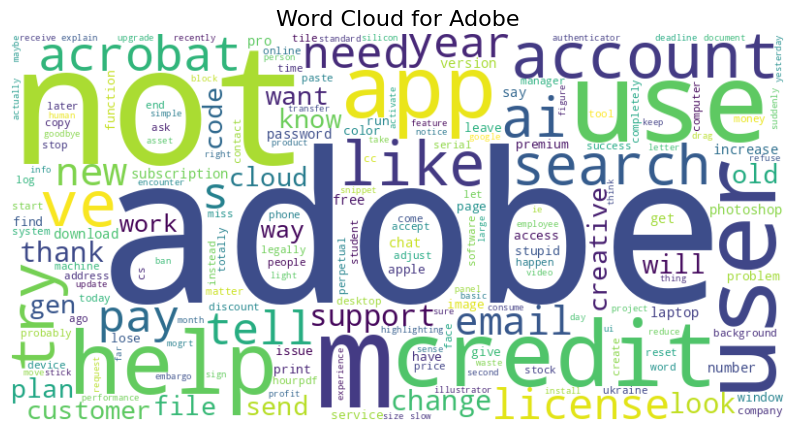

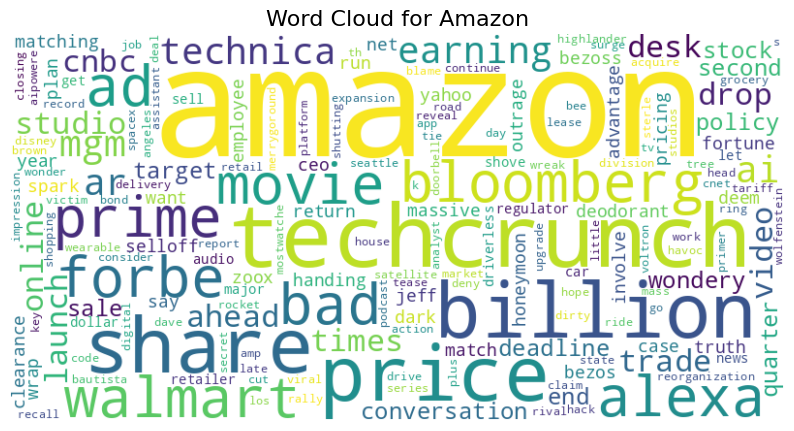

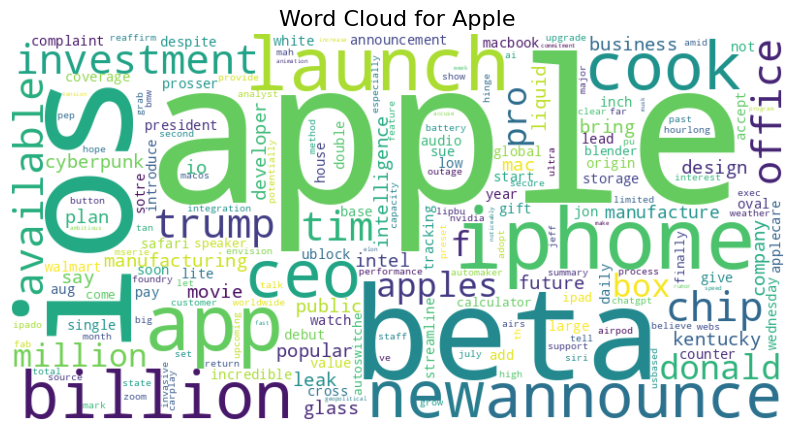

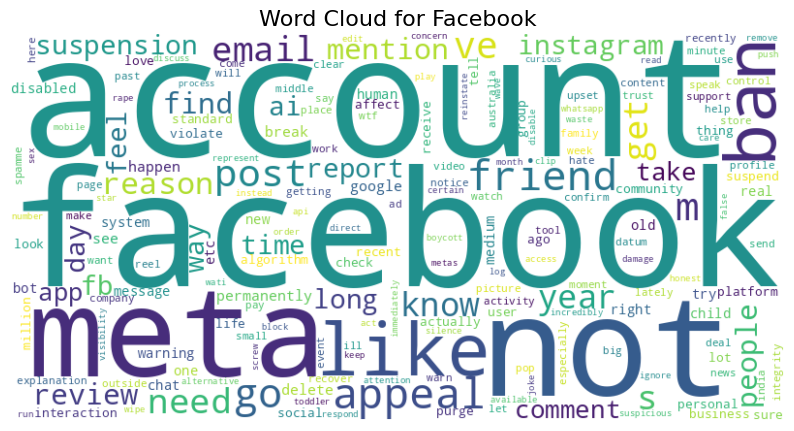

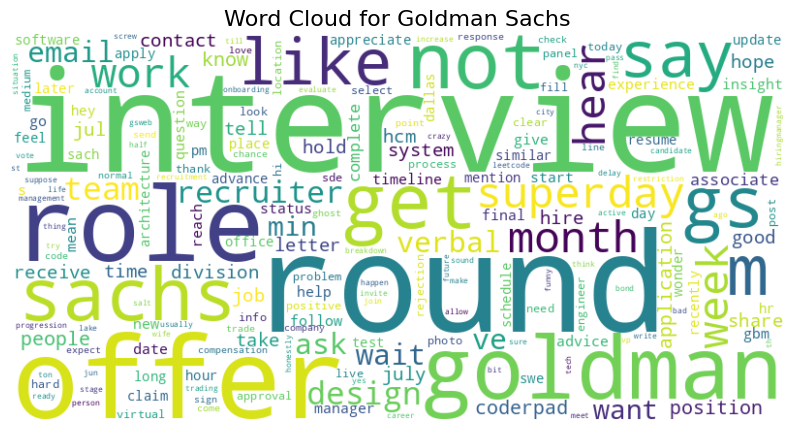

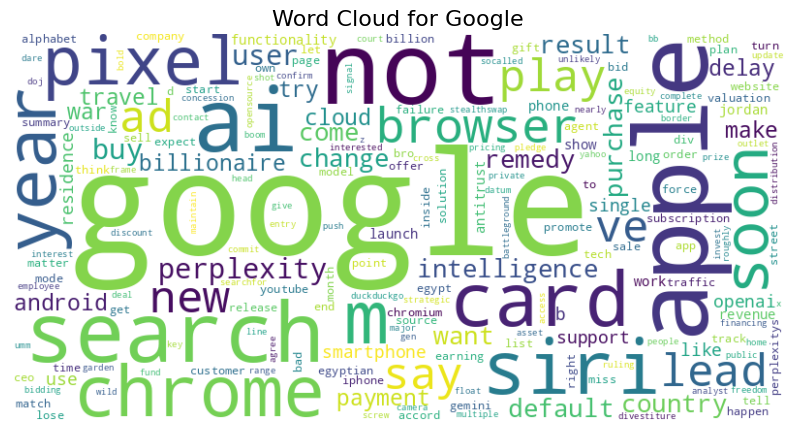

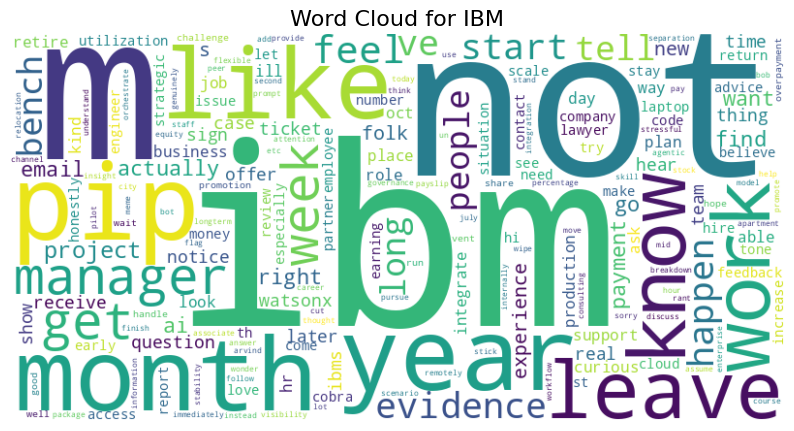

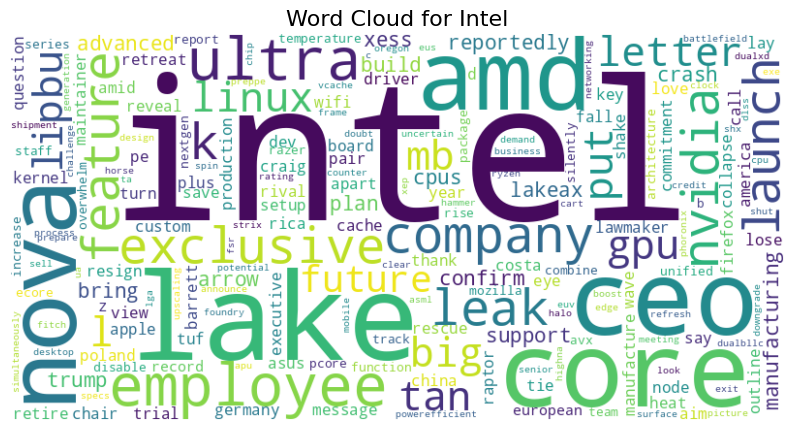

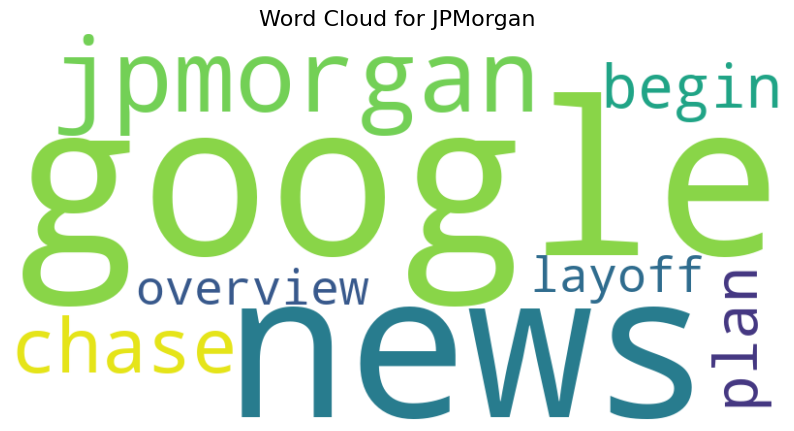

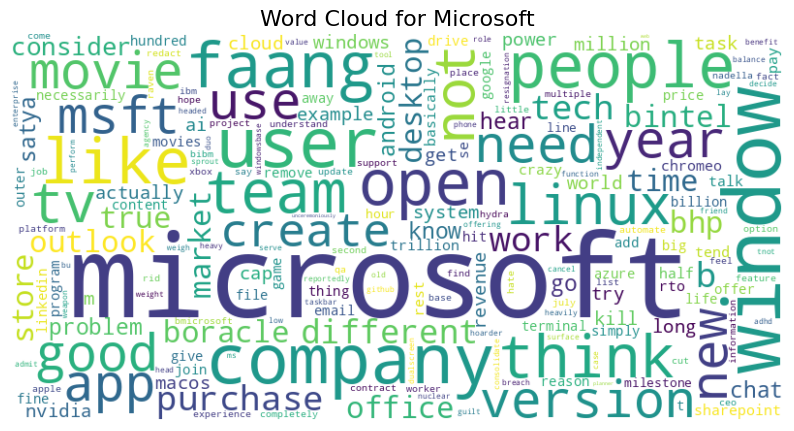

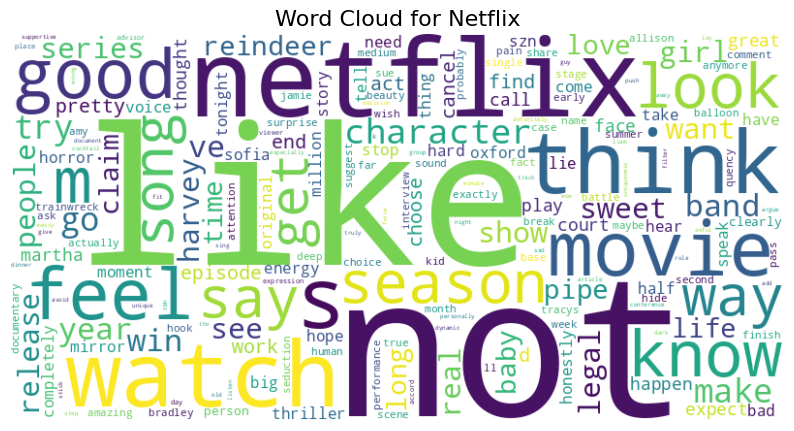

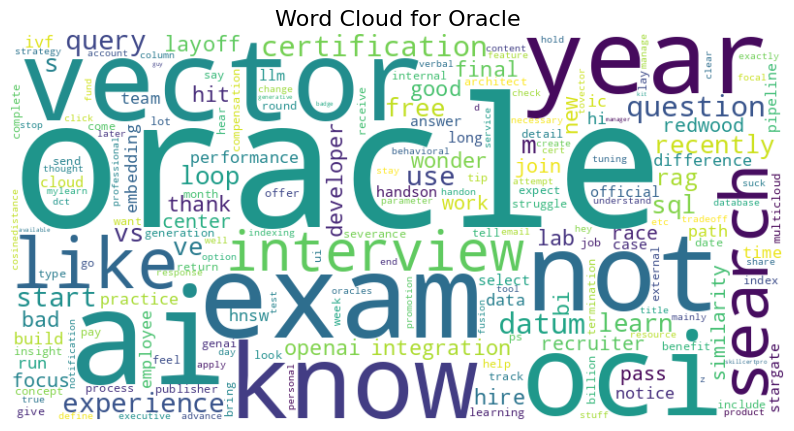

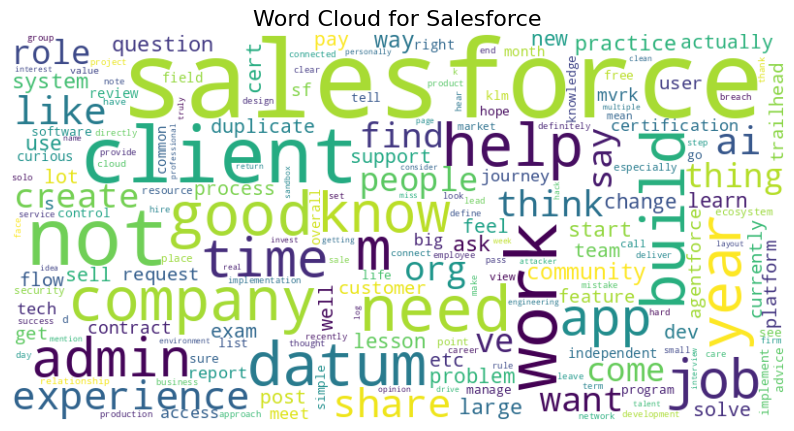

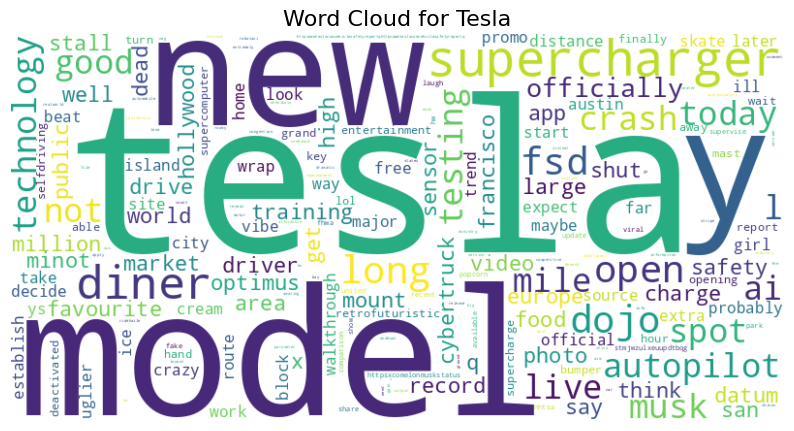

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Loop through each company
for company, word_freq_df in company_word_freqs.items():
    # Convert to dictionary (WordCloud expects dict {word: freq})
    freq_dict = dict(zip(word_freq_df["Word"], word_freq_df["Frequency"]))

    # Generate wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {company}", fontsize=16)
    plt.show()


# TFIDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Join lemmas back into string form (since TF-IDF expects text, not tokens)
df["lemmas_str"] = df["lemmas"].apply(lambda x: " ".join(x))

# Apply TF-IDF
tfidf = TfidfVectorizer(max_features=1000)  # keep top 1000 features
X = tfidf.fit_transform(df["lemmas_str"])

# Create dataframe of TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=tfidf.get_feature_names_out(), index=df["Company"])

print(tfidf_df.tail())


            able  absolutely  accept  access  accord  account  acrobat  act  \
Company                                                                       
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   
Salesforce   0.0         0.0     0.0     0.0     0.0      0.0      0.0  0.0   

            action  activate  ...      work  world  worth  write  wrong  wtf  \
Company                       ...                                              
Salesforce     0.0       0.0  ...  0.108819    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000    0.0    0.0    0.0    0.0  0.0   
Salesforce     0.0       0.0  ...  0.000000   

In [16]:
tfidf_df.index = df.index

# Group by company and take mean
company_tfidf = tfidf_df.groupby(df["Company"]).mean()

# Now company names will be index
print(company_tfidf.index.tolist())

['Adobe', 'Amazon', 'Apple', 'Facebook', 'Goldman Sachs', 'Google', 'IBM', 'Intel', 'JPMorgan', 'Microsoft', 'Netflix', 'Oracle', 'Salesforce', 'Tesla']


In [17]:
# Top 10 words for Salesforce
salesforce_top = company_tfidf.loc["Salesforce"].sort_values(ascending=False).head(15)
print(salesforce_top)

salesforce    0.181552
admin         0.056010
datum         0.054148
not           0.053012
work          0.051565
flow          0.046014
cert          0.044313
app           0.043400
agentforce    0.043248
org           0.040917
ai            0.038548
know          0.038129
think         0.037598
company       0.036905
experience    0.035633
Name: Salesforce, dtype: float64


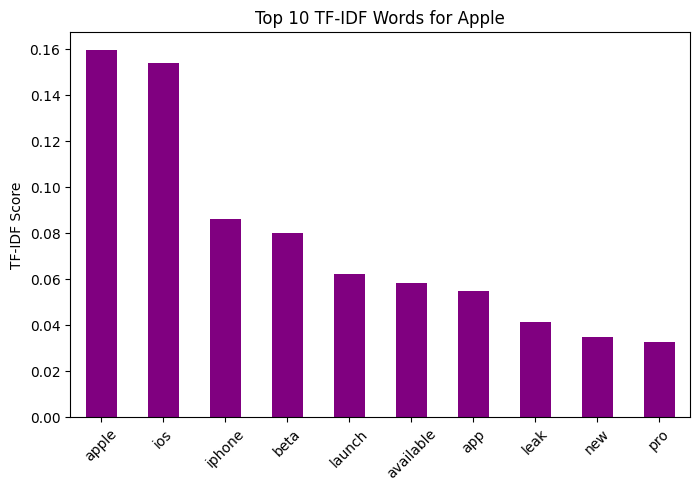

In [18]:
company = "Apple"
top_words = company_tfidf.loc[company].sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top_words.plot(kind="bar", color="purple")
plt.title(f"Top 10 TF-IDF Words for {company}")
plt.ylabel("TF-IDF Score")
plt.xticks(rotation=45)
plt.show()


In [19]:
top_words_per_company = {}

for company in company_tfidf.index:
    top_words = company_tfidf.loc[company].sort_values(ascending=False).head(5).index.tolist()
    top_words_per_company[company] = top_words

print(top_words_per_company)

{'Adobe': ['adobe', 'not', 'photoshop', 'use', 'acrobat'], 'Amazon': ['amazon', 'techcrunch', 'ar', 'bloomberg', 'forbe'], 'Apple': ['apple', 'ios', 'iphone', 'beta', 'launch'], 'Facebook': ['facebook', 'account', 'ban', 'meta', 'like'], 'Goldman Sachs': ['interview', 'round', 'offer', 'goldman', 'role'], 'Google': ['google', 'search', 'earning', 'card', 'ai'], 'IBM': ['ibm', 'bench', 'discuss', 'not', 'know'], 'Intel': ['intel', 'lake', 'ceo', 'amd', 'nova'], 'JPMorgan': ['layoff', 'news', 'plan', 'google', 'pop'], 'Microsoft': ['microsoft', 'window', 'kill', 'true', 'tv'], 'Netflix': ['netflix', 'like', 'watch', 'season', 'not'], 'Oracle': ['oracle', 'oci', 'year', 'layoff', 'ai'], 'Salesforce': ['salesforce', 'admin', 'datum', 'not', 'work'], 'Tesla': ['tesla', 'model', 'supercharger', 'new', 'diner']}


In [20]:
df.head()

Company                                      cleaned_title  \
0  Facebook  facebook needs to be investigated they priorit...   
1  Facebook  am i wrong deleted both facebook and instagram...   
2  Facebook  disabled account in fb for no absolutely no re...   
3  Facebook  apparently facebook is insinuating you are a p...   
4  Facebook  good as they should you cant just falsely accu...   

                                        cleaned_post  \
0  lately ive been noticing that facebooks algori...   
1  so i permanently deleted my facebook and insta...   
2  am i the only one who is experiencing this pls...   
3                                                      
4                                                      

                                       combined_text  \
0  facebook needs to be investigated they priorit...   
1  am i wrong deleted both facebook and instagram...   
2  disabled account in fb for no absolutely no re...   
3  apparently facebook is insinuating you are a p...   
4  good as they should you cant just falsely accu...   

                                              lemmas  \
0  [facebook, need, investigate, prioritize, hate...   
1  [wrong, delete, facebook, instagram, permanent...   
2  [disabled, account, fb, absolutely, reason, wa...   
3  [apparently, facebook, insinuate, peadophile, ...   
4  [good, not, falsely, accuse, people, disrupt, ...   

                                          lemmas_str  
0  facebook need investigate prioritize hate spee...  
1  wrong delete facebook instagram permanently m ...  
2  disabled account fb absolutely reason warning ...  
3  apparently facebook insinuate peadophile like ...  
4  good not falsely accuse people disrupt life bu...

# Sentimental Analysis

In [21]:
from textblob import TextBlob

df['sentiment'] = df['combined_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df


Company                                      cleaned_title  \
0      Facebook  facebook needs to be investigated they priorit...   
1      Facebook  am i wrong deleted both facebook and instagram...   
2      Facebook  disabled account in fb for no absolutely no re...   
3      Facebook  apparently facebook is insinuating you are a p...   
4      Facebook  good as they should you cant just falsely accu...   
..          ...                                                ...   
386  Salesforce       individual utilization rates for consultants   
387  Salesforce                      appstools that document flows   
388  Salesforce                   accidental admin salary increase   
389  Salesforce                 do you make changes in productions   
390  Salesforce                     how to eliminate unused fields   

                                          cleaned_post  \
0    lately ive been noticing that facebooks algori...   
1    so i permanently deleted my facebook and insta...   
2    am i the only one who is experiencing this pls...   
3                                                        
4                                                        
..                                                 ...   
386  for the consultants out there what is the targ...   
387  are there any apps or tools that can document ...   
388  i am a tech support for a software company in ...   
389  hi trailblazers this is mainly for my fellow s...   
390  the org i am starting to work on has more than...   

                                         combined_text  \
0    facebook needs to be investigated they priorit...   
1    am i wrong deleted both facebook and instagram...   
2    disabled account in fb for no absolutely no re...   
3    apparently facebook is insinuating you are a p...   
4    good as they should you cant just falsely accu...   
..                                                 ...   
386  individual utilization rates for consultants f...   
387  appstools that document flows are there any ap...   
388  accidental admin salary increase i am a tech s...   
389  do you make changes in productions hi trailbla...   
390  how to eliminate unused fields the org i am st...   

                                                lemmas  \
0    [facebook, need, investigate, prioritize, hate...   
1    [wrong, delete, facebook, instagram, permanent...   
2    [disabled, account, fb, absolutely, reason, wa...   
3    [apparently, facebook, insinuate, peadophile, ...   
4    [good, not, falsely, accuse, people, disrupt, ...   
..                                                 ...   
386  [individual, utilization, rate, consultant, co...   
387  [appstool, document, flow, app, tool, document...   
388  [accidental, admin, salary, increase, tech, su...   
389  [change, production, hi, trailblazer, mainly, ...   
390  [eliminate, unused, field, org, start, work, c...   

                                            lemmas_str  sentiment  
0    facebook need investigate prioritize hate spee...  -0.275132  
1    wrong delete facebook instagram permanently m ...   0.070370  
2    disabled account fb absolutely reason warning ...  -0.009259  
3    apparently facebook insinuate peadophile like ...   0.050000  
4    good not falsely accuse people disrupt life bu...   0.150000  
..                                                 ...        ...  
386  individual utilization rate consultant consult...   0.066667  
387      appstool document flow app tool document flow   0.000000  
388  accidental admin salary increase tech support ...   0.086979  
389  change production hi trailblazer mainly fellow...   0.096272  
390  eliminate unused field org start work custom f...   0.216667  

[391 rows x 7 columns]

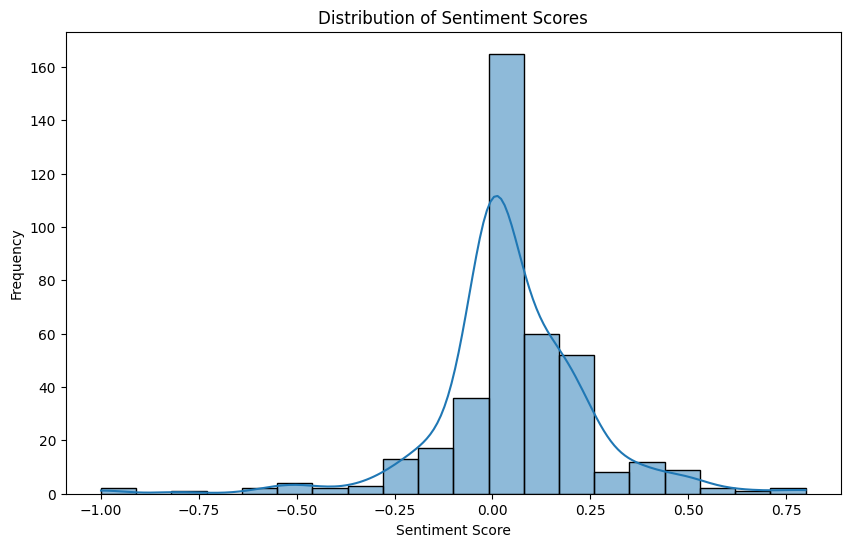

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

/tmp/ipython-input-1614305404.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=company_sentiment.index, y=company_sentiment.values, palette='viridis')


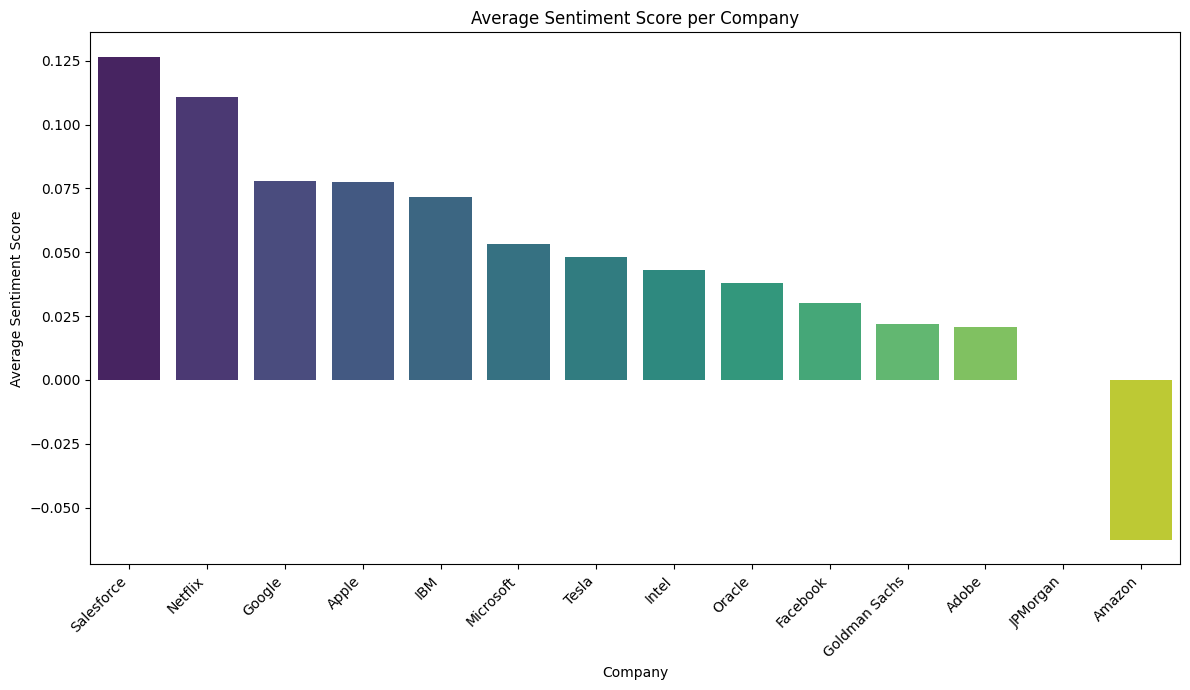

In [23]:
company_sentiment = df.groupby('Company')['sentiment'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=company_sentiment.index, y=company_sentiment.values, palette='viridis')
plt.title('Average Sentiment Score per Company')
plt.xlabel('Company')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [24]:
!pip install transformers torch datasets


In [25]:
texts = df['lemmas_str'].tolist()

In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load tokenizer and model
model_name = "finiteautomata/bertweet-base-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment-analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Device set to use cpu


In [27]:
# Example on first 3 posts
for text in texts[:3]:
    print(sentiment_pipeline(text))


[{'label': 'NEG', 'score': 0.9552006125450134}]
[{'label': 'NEG', 'score': 0.9770522117614746}]
[{'label': 'NEG', 'score': 0.9314349889755249}]


In [30]:
df['sentiment'] = df['lemmas_str'].apply(lambda x: sentiment_pipeline(x[:128])[0]['label'])
df['sentiment_score'] = df['lemmas_str'].apply(lambda x: sentiment_pipeline(x[:128])[0]['score'])

print(df[['lemmas_str', 'sentiment', 'sentiment_score']])


                                            lemmas_str sentiment  \
0    facebook need investigate prioritize hate spee...       NEG   
1    wrong delete facebook instagram permanently m ...       NEG   
2    disabled account fb absolutely reason warning ...       NEG   
3    apparently facebook insinuate peadophile like ...       NEG   
4    good not falsely accuse people disrupt life bu...       NEU   
..                                                 ...       ...   
386  individual utilization rate consultant consult...       NEU   
387      appstool document flow app tool document flow       NEU   
388  accidental admin salary increase tech support ...       NEG   
389  change production hi trailblazer mainly fellow...       NEU   
390  eliminate unused field org start work custom f...       NEU   

     sentiment_score  
0           0.969051  
1           0.966798  
2           0.954633  
3           0.937144  
4           0.523158  
..               ...  
386         0.941096  